# CCFRP data: convert grid-level data to DwC, separate MeasurementOrFact file

Draws code from earlier conversion draft: CCFRP_grid-level_conversion.ipynb

### Resources
- https://dwc.tdwg.org/terms/
- https://tools.gbif.org/dwca-validator/extension.do?id=dwc:Occurrence
- https://www.gbif.org/data-quality-requirements-occurrences

### Preprocessing
CCFRP data were originally shared as an excel file (CPUE_IDcell_Summary_Tables_2019.xls) with multiple sheets. Saved each sheet as a .csv:
1. CPUE.per.IDcell_2019 --> Grid-level_CPUE.csv
2. Counts.per.IDcell_2019 --> Grid-level_Counts.csv

This could be automated if desired.


In [1]:
## Imports

import pandas as pd
import numpy as np
import random

from datetime import datetime # for handline dates

In [2]:
## Ensure my general functions for the MPA data integration project can be imported, and import them

import sys
sys.path.insert(0, "C:\\Users\\dianalg\\PycharmProjects\\PythonScripts\\MPA data integration")

import WoRMS # functions for querying WoRMS REST API

## Load data

In [3]:
## Load grid-level count data

path = 'C:\\Users\\dianalg\\Documents\\Work\\MBARI\\MPA Data Integration\\CCFRP\\'
filename = 'Grid-level_Counts_200630.csv'
data = pd.read_csv(path+filename)

data.head()

,ID.Cell.per.Trip,Date,Area,Site,Year,Total.Angler.Hours,Grid.Cell.ID,Lat Center Point,Lon Center Point,Lat 1,...,Vermilion Rockfish,White Croaker,White Seabass,Widow Rockfish,Wolf Eel,Yelloweye Rockfish,Yellowfin Croaker,Yellowtail Jack,Yellowtail Rockfish,Total
0,AIM09181901,9/18/2019,Anacapa Island,MPA,2019,5.750000,AI01,34.0215,-119.3668,34.0189,...,0,0,0,0,0,0,0,0,0,123
1,AIM09191901,9/19/2019,Anacapa Island,MPA,2019,6.033333,AI01,34.0215,-119.3668,34.0189,...,0,0,0,0,0,0,0,0,0,121
2,AIM10251701,10/25/2017,Anacapa Island,MPA,2017,7.329722,AI01,34.0215,-119.3668,34.0189,...,0,0,0,0,0,0,0,0,0,161
3,AIM10291801,10/29/2018,Anacapa Island,MPA,2018,4.416667,AI01,34.0215,-119.3668,34.0189,...,0,0,0,0,0,0,0,0,0,33
4,AIM10181802,10/18/2018,Anacapa Island,MPA,2018,4.916667,AI02,34.0204,-119.3723,34.0220,...,0,0,0,0,0,0,0,0,0,59


In [4]:
## Load scientific names

path = 'C:\\Users\\dianalg\\PycharmProjects\\PythonScripts\\MPA data integration\\CCFRP\\'
filename = 'CCFRP_common_to_scientific.csv'
species = pd.read_csv(path+filename)

species.head()

,common_names,scientific_names
0,Bigmouth Sole,Hippoglossina stomata
1,Longfin Sanddab,Citharichthys xanthostigma
2,Pacific Halibut,Hippoglossus stenolepis
3,Pelagic Stingray,Pteroplatytrygon violacea
4,Northern Anchovy,Engraulis mordax


In [5]:
## Load CPUE data

path = 'C:\\Users\\dianalg\\Documents\\Work\\MBARI\\MPA Data Integration\\CCFRP\\'
filename = 'Grid-level_CPUE_200630.csv'
cpue = pd.read_csv(path+filename)

cpue.head()

,ID.Cell.per.Trip,Date,Area,Site,Year,Total.Angler.Hours,Grid.Cell.ID,Lat Center Point,Lon Center Point,Lat 1,...,Vermilion Rockfish,White Croaker,White Seabass,Widow Rockfish,Wolf Eel,Yelloweye Rockfish,Yellowfin Croaker,Yellowtail Jack,Yellowtail Rockfish,Total
0,AIM09181901,9/18/2019,Anacapa Island,MPA,2019,5.750000,AI01,34.0215,-119.3668,34.0189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.391304
1,AIM09191901,9/19/2019,Anacapa Island,MPA,2019,6.033333,AI01,34.0215,-119.3668,34.0189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.055249
2,AIM10251701,10/25/2017,Anacapa Island,MPA,2017,7.329722,AI01,34.0215,-119.3668,34.0189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.965362
3,AIM10291801,10/29/2018,Anacapa Island,MPA,2018,4.416667,AI01,34.0215,-119.3668,34.0189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.471698
4,AIM10181802,10/18/2018,Anacapa Island,MPA,2018,4.916667,AI02,34.0204,-119.3723,34.0220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.000000


### Convert from wide to long format

In [6]:
## Drop Total column

data.drop('Total', axis=1, inplace=True)

In [7]:
## Melt data

data_long = pd.melt(data, id_vars=data.columns[0:17].tolist(), var_name='species_common_name', value_name='count')
print(data_long.shape)
data_long.head()

(193140, 19)


,ID.Cell.per.Trip,Date,Area,Site,Year,Total.Angler.Hours,Grid.Cell.ID,Lat Center Point,Lon Center Point,Lat 1,Lon 1,Lat 2,Lon 2,Lat 3,Lon 3,Lat 4,Lon 4,species_common_name,count
0,AIM09181901,9/18/2019,Anacapa Island,MPA,2019,5.750000,AI01,34.0215,-119.3668,34.0189,-119.3689,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,Barred Sand Bass,0
1,AIM09191901,9/19/2019,Anacapa Island,MPA,2019,6.033333,AI01,34.0215,-119.3668,34.0189,-119.3689,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,Barred Sand Bass,0
2,AIM10251701,10/25/2017,Anacapa Island,MPA,2017,7.329722,AI01,34.0215,-119.3668,34.0189,-119.3689,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,Barred Sand Bass,0
3,AIM10291801,10/29/2018,Anacapa Island,MPA,2018,4.416667,AI01,34.0215,-119.3668,34.0189,-119.3689,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,Barred Sand Bass,0
4,AIM10181802,10/18/2018,Anacapa Island,MPA,2018,4.916667,AI02,34.0204,-119.3723,34.0220,-119.3757,34.0232,-119.3705,34.0189,-119.3690,34.0176,-119.3742,Barred Sand Bass,0


### Join to obtain scientific names

In [8]:
## Merge

data_long = data_long.merge(species, how='left', left_on='species_common_name', right_on='common_names')
data_long.head()

,ID.Cell.per.Trip,Date,Area,Site,Year,Total.Angler.Hours,Grid.Cell.ID,Lat Center Point,Lon Center Point,Lat 1,...,Lat 2,Lon 2,Lat 3,Lon 3,Lat 4,Lon 4,species_common_name,count,common_names,scientific_names
0,AIM09181901,9/18/2019,Anacapa Island,MPA,2019,5.750000,AI01,34.0215,-119.3668,34.0189,...,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,Barred Sand Bass,0,Barred Sand Bass,Paralabrax nebulifer
1,AIM09191901,9/19/2019,Anacapa Island,MPA,2019,6.033333,AI01,34.0215,-119.3668,34.0189,...,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,Barred Sand Bass,0,Barred Sand Bass,Paralabrax nebulifer
2,AIM10251701,10/25/2017,Anacapa Island,MPA,2017,7.329722,AI01,34.0215,-119.3668,34.0189,...,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,Barred Sand Bass,0,Barred Sand Bass,Paralabrax nebulifer
3,AIM10291801,10/29/2018,Anacapa Island,MPA,2018,4.416667,AI01,34.0215,-119.3668,34.0189,...,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,Barred Sand Bass,0,Barred Sand Bass,Paralabrax nebulifer
4,AIM10181802,10/18/2018,Anacapa Island,MPA,2018,4.916667,AI02,34.0204,-119.3723,34.0220,...,34.0232,-119.3705,34.0189,-119.3690,34.0176,-119.3742,Barred Sand Bass,0,Barred Sand Bass,Paralabrax nebulifer


In [9]:
## Drop unnecessary columns

data_long.drop(['species_common_name', 'common_names'], axis=1, inplace=True)
data_long.head()

,ID.Cell.per.Trip,Date,Area,Site,Year,Total.Angler.Hours,Grid.Cell.ID,Lat Center Point,Lon Center Point,Lat 1,Lon 1,Lat 2,Lon 2,Lat 3,Lon 3,Lat 4,Lon 4,count,scientific_names
0,AIM09181901,9/18/2019,Anacapa Island,MPA,2019,5.750000,AI01,34.0215,-119.3668,34.0189,-119.3689,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,0,Paralabrax nebulifer
1,AIM09191901,9/19/2019,Anacapa Island,MPA,2019,6.033333,AI01,34.0215,-119.3668,34.0189,-119.3689,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,0,Paralabrax nebulifer
2,AIM10251701,10/25/2017,Anacapa Island,MPA,2017,7.329722,AI01,34.0215,-119.3668,34.0189,-119.3689,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,0,Paralabrax nebulifer
3,AIM10291801,10/29/2018,Anacapa Island,MPA,2018,4.416667,AI01,34.0215,-119.3668,34.0189,-119.3689,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,0,Paralabrax nebulifer
4,AIM10181802,10/18/2018,Anacapa Island,MPA,2018,4.916667,AI02,34.0204,-119.3723,34.0220,-119.3757,34.0232,-119.3705,34.0189,-119.3690,34.0176,-119.3742,0,Paralabrax nebulifer


In [10]:
## Groupby to handle the fact that Unknown rockfish and Olive or yellowtail rockfish both match to 'Sebastes'; UnID blue rockfish and Blue rockfish both match to 'Sebastes mystinus'

data_long = data_long.groupby(['ID.Cell.per.Trip', 'Date', 'Area', 'Site', 'Year',
                               'Total.Angler.Hours', 'Grid.Cell.ID', 'Lat Center Point',
                               'Lon Center Point', 'Lat 1', 'Lon 1', 'Lat 2', 'Lon 2', 'Lat 3',
                               'Lon 3', 'Lat 4', 'Lon 4', 'scientific_names']).sum()
data_long.reset_index(inplace=True)

print(data_long.shape)
data_long.head()

(188848, 19)


,ID.Cell.per.Trip,Date,Area,Site,Year,Total.Angler.Hours,Grid.Cell.ID,Lat Center Point,Lon Center Point,Lat 1,Lon 1,Lat 2,Lon 2,Lat 3,Lon 3,Lat 4,Lon 4,scientific_names,count
0,AIM09171903,9/17/2019,Anacapa Island,MPA,2019,5.216667,AI03,34.0177,-119.3795,34.0189,-119.3831,34.0206,-119.3781,34.0165,-119.376,34.0148,-119.381,Alopias vulpinus,0
1,AIM09171903,9/17/2019,Anacapa Island,MPA,2019,5.216667,AI03,34.0177,-119.3795,34.0189,-119.3831,34.0206,-119.3781,34.0165,-119.376,34.0148,-119.381,Anarrhichthys ocellatus,0
2,AIM09171903,9/17/2019,Anacapa Island,MPA,2019,5.216667,AI03,34.0177,-119.3795,34.0189,-119.3831,34.0206,-119.3781,34.0165,-119.376,34.0148,-119.381,Artedius harringtoni,0
3,AIM09171903,9/17/2019,Anacapa Island,MPA,2019,5.216667,AI03,34.0177,-119.3795,34.0189,-119.3831,34.0206,-119.3781,34.0165,-119.376,34.0148,-119.381,Atherinops affinis,0
4,AIM09171903,9/17/2019,Anacapa Island,MPA,2019,5.216667,AI03,34.0177,-119.3795,34.0189,-119.3831,34.0206,-119.3781,34.0165,-119.376,34.0148,-119.381,Atherinopsidae,0


## Assemble occurrence file

In [11]:
### Build eventID and put it in a new data frame

eventID = data_long['ID.Cell.per.Trip']
converted = pd.DataFrame({'eventID':eventID})
converted.head()

,eventID
0,AIM09171903
1,AIM09171903
2,AIM09171903
3,AIM09171903
4,AIM09171903


In [12]:
## Format dates and add eventDate

eventDate = [datetime.strptime(dt, '%m/%d/%Y').date().isoformat() for dt in data_long['Date']]
converted['eventDate'] = eventDate
converted.head()

,eventID,eventDate
0,AIM09171903,2019-09-17
1,AIM09171903,2019-09-17
2,AIM09171903,2019-09-17
3,AIM09171903,2019-09-17
4,AIM09171903,2019-09-17


In [13]:
## Add datasetID

converted['datasetID'] = 'CCFRP'
converted.head()

,eventID,eventDate,datasetID
0,AIM09171903,2019-09-17,CCFRP
1,AIM09171903,2019-09-17,CCFRP
2,AIM09171903,2019-09-17,CCFRP
3,AIM09171903,2019-09-17,CCFRP
4,AIM09171903,2019-09-17,CCFRP


In [14]:
## Add locality and locationRemarks

converted['locality'] = data_long['Area']
converted['locationRemarks'] = data_long['Site']

# Change MPA and REF to something more interpretable
habitat_dict = {
    'REF':'fished area',
    'MPA':'marine protected area'
}
converted['locationRemarks'].replace(habitat_dict, inplace=True)
converted.head()

,eventID,eventDate,datasetID,locality,locationRemarks
0,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area
1,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area
2,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area
3,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area
4,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area


In [15]:
## Add countryCode

converted['countryCode'] = 'US'
converted.head()

,eventID,eventDate,datasetID,locality,locationRemarks,countryCode
0,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US
1,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US
2,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US
3,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US
4,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US


In [16]:
%%time

## Add the bounding box of the grid cell as footprintWKT

bb = ['POLYGON ((' + str(data_long['Lat 3'].iloc[i]) + ' ' + str(data_long['Lon 3'].iloc[i]) + ', ' + \
        str(data_long['Lat 1'].iloc[i]) + ' ' + str(data_long['Lon 1'].iloc[i]) + ', ' + \
        str(data_long['Lat 2'].iloc[i]) + ' ' + str(data_long['Lon 2'].iloc[i]) + ', ' + \
        str(data_long['Lat 4'].iloc[i]) + ' ' + str(data_long['Lon 4'].iloc[i]) + ', ' + \
        str(data_long['Lat 3'].iloc[i]) + ' ' + str(data_long['Lon 3'].iloc[i]) + '))' for i in range(data_long.shape[0])]
converted['footprintWKT'] = bb
converted.head()

Wall time: 14.2 s


,eventID,eventDate,datasetID,locality,locationRemarks,countryCode,footprintWKT
0,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,..."
1,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,..."
2,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,..."
3,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,..."
4,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,..."


In [65]:
## Add decimal latitude and decimal longitude

converted['decimalLatitude'] = data_long['Lat Center Point']
converted['decimalLongitude'] = data_long['Lon Center Point']
converted.head()

,eventID,eventDate,datasetID,locality,locationRemarks,countryCode,footprintWKT,decimalLatitude,decimalLongitude
0,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795
1,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795
2,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795
3,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795
4,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795


In [66]:
## Add coordinateUncertaintyInMeters

converted['coordinateUncertaintyInMeters'] = 354 
converted.head()

,eventID,eventDate,datasetID,locality,locationRemarks,countryCode,footprintWKT,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters
0,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354
1,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354
2,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354
3,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354
4,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354


In [67]:
## Add samplingEffort

converted['samplingEffort'] = '30-45 minutes of timed fishing activity conducted along 1-3 drifts by between 4 and 18 volunteer anglers (mode of 12)'
converted.head()

,eventID,eventDate,datasetID,locality,locationRemarks,countryCode,footprintWKT,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,samplingEffort
0,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...
1,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...
2,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...
3,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...
4,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...


In [68]:
## Add occurrenceID

converted['occurrenceID'] = converted.groupby('eventID').cumcount()+1
converted['occurrenceID'] = converted['eventID'] + '_occ' + converted['occurrenceID'].astype(str)
converted.head()

,eventID,eventDate,datasetID,locality,locationRemarks,countryCode,footprintWKT,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,samplingEffort,occurrenceID
0,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ1
1,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ2
2,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ3
3,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ4
4,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ5


### Access WoRMS to add species information

In [69]:
## Get unique scientific names, remove nan's

sci_names = data_long['scientific_names'].copy().dropna().unique()

In [73]:
## Chromus punctipinnis is misspelled in the data as Chromus punctipinnus. Correcting:

sci_names[sci_names == ['Chromis punctipinnus']] = 'Chromis punctipinnis'

In [74]:
%%time

## Call run_get_worms_from_scientific_name

name_id_dict, name_name_dict, name_taxid_dict = WoRMS.run_get_worms_from_scientific_name(sci_names, verbose_flag=True)

Wall time: 1min 2s


In [75]:
## Add scientific name-related columns

converted['scientificName'] = data_long['scientific_names']

converted['scientificNameID'] = data_long['scientific_names']
converted['scientificNameID'].replace(name_id_dict, inplace=True)

converted['taxonID'] = data_long['scientific_names']
converted['taxonID'].replace(name_taxid_dict, inplace=True)
converted.head()

,eventID,eventDate,datasetID,locality,locationRemarks,countryCode,footprintWKT,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,samplingEffort,occurrenceID,scientificName,scientificNameID,taxonID
0,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ1,Alopias vulpinus,urn:lsid:marinespecies.org:taxname:105836,105836
1,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ2,Anarrhichthys ocellatus,urn:lsid:marinespecies.org:taxname:279605,279605
2,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ3,Artedius harringtoni,urn:lsid:marinespecies.org:taxname:279701,279701
3,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ4,Atherinops affinis,urn:lsid:marinespecies.org:taxname:279812,279812
4,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ5,Atherinopsidae,urn:lsid:marinespecies.org:taxname:266995,266995


In [76]:
## Create identificationQualifier to handle Sebastes serranoides or flavidus species name

identificationQualifier = ['Sebastes serranoides or Sebastes flavidus' if name == 'Sebastes serranoides or flavidus' else np.nan for name in converted['scientificName']]

In [77]:
## Replace scientificName using name_name_dict

converted['scientificName'].replace(name_name_dict, inplace=True)

In [78]:
## Add final name-related columns

converted['nameAccordingTo'] = 'WoRMS'
converted['identificationQualifier'] = identificationQualifier
converted['occurrenceStatus'] = 'present'
converted['basisOfRecord'] = 'HumanObservation'

converted.head()

,eventID,eventDate,datasetID,locality,locationRemarks,countryCode,footprintWKT,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,samplingEffort,occurrenceID,scientificName,scientificNameID,taxonID,nameAccordingTo,identificationQualifier,occurrenceStatus,basisOfRecord
0,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ1,Alopias vulpinus,urn:lsid:marinespecies.org:taxname:105836,105836,WoRMS,NaN,present,HumanObservation
1,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ2,Anarrhichthys ocellatus,urn:lsid:marinespecies.org:taxname:279605,279605,WoRMS,NaN,present,HumanObservation
2,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ3,Artedius harringtoni,urn:lsid:marinespecies.org:taxname:279701,279701,WoRMS,NaN,present,HumanObservation
3,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ4,Atherinops affinis,urn:lsid:marinespecies.org:taxname:279812,279812,WoRMS,NaN,present,HumanObservation
4,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ5,Atherinopsidae,urn:lsid:marinespecies.org:taxname:266995,266995,WoRMS,NaN,present,HumanObservation


### Add count data

In [80]:
## Add count data

converted['individualCount'] = data_long['count']
converted.head()

,eventID,eventDate,datasetID,locality,locationRemarks,countryCode,footprintWKT,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,samplingEffort,occurrenceID,scientificName,scientificNameID,taxonID,nameAccordingTo,identificationQualifier,occurrenceStatus,basisOfRecord,individualCount
0,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ1,Alopias vulpinus,urn:lsid:marinespecies.org:taxname:105836,105836,WoRMS,NaN,present,HumanObservation,0
1,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ2,Anarrhichthys ocellatus,urn:lsid:marinespecies.org:taxname:279605,279605,WoRMS,NaN,present,HumanObservation,0
2,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ3,Artedius harringtoni,urn:lsid:marinespecies.org:taxname:279701,279701,WoRMS,NaN,present,HumanObservation,0
3,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ4,Atherinops affinis,urn:lsid:marinespecies.org:taxname:279812,279812,WoRMS,NaN,present,HumanObservation,0
4,AIM09171903,2019-09-17,CCFRP,Anacapa Island,marine protected area,US,"POLYGON ((34.0165 -119.376, 34.0189 -119.3831,...",34.0177,-119.3795,354,30-45 minutes of timed fishing activity conduc...,AIM09171903_occ5,Atherinopsidae,urn:lsid:marinespecies.org:taxname:266995,266995,WoRMS,NaN,present,HumanObservation,0


In [81]:
## Update occurrenceStatus based on count

converted.loc[converted['individualCount'] == 0, ['occurrenceStatus']] = 'absent'

## Save occurrence file

In [82]:
## Save

converted.to_csv('CCFRP_grid-level_occurrence.csv', index=False, na_rep='NaN')

## Create MeasurementOrFact file

### Load CPUE data

In [83]:
## Perform initial processing steps and convert to long-form

# Drop species 'Total'
cpue.drop('Total', axis=1, inplace=True)

## Melt data
cpue_long = pd.melt(cpue, id_vars=data.columns[0:17].tolist(), var_name='species_common_name', value_name='cpue')
cpue_long.head()

,ID.Cell.per.Trip,Date,Area,Site,Year,Total.Angler.Hours,Grid.Cell.ID,Lat Center Point,Lon Center Point,Lat 1,Lon 1,Lat 2,Lon 2,Lat 3,Lon 3,Lat 4,Lon 4,species_common_name,cpue
0,AIM09181901,9/18/2019,Anacapa Island,MPA,2019,5.750000,AI01,34.0215,-119.3668,34.0189,-119.3689,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,Barred Sand Bass,0.0
1,AIM09191901,9/19/2019,Anacapa Island,MPA,2019,6.033333,AI01,34.0215,-119.3668,34.0189,-119.3689,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,Barred Sand Bass,0.0
2,AIM10251701,10/25/2017,Anacapa Island,MPA,2017,7.329722,AI01,34.0215,-119.3668,34.0189,-119.3689,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,Barred Sand Bass,0.0
3,AIM10291801,10/29/2018,Anacapa Island,MPA,2018,4.416667,AI01,34.0215,-119.3668,34.0189,-119.3689,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,Barred Sand Bass,0.0
4,AIM10181802,10/18/2018,Anacapa Island,MPA,2018,4.916667,AI02,34.0204,-119.3723,34.0220,-119.3757,34.0232,-119.3705,34.0189,-119.3690,34.0176,-119.3742,Barred Sand Bass,0.0


In [84]:
## Merge and remove unnecessary columns

# Merge
cpue_long = cpue_long.merge(species, how='left', left_on='species_common_name', right_on='common_names')

# Drop
cpue_long.drop(['species_common_name', 'common_names'], axis=1, inplace=True)
cpue_long.head()

,ID.Cell.per.Trip,Date,Area,Site,Year,Total.Angler.Hours,Grid.Cell.ID,Lat Center Point,Lon Center Point,Lat 1,Lon 1,Lat 2,Lon 2,Lat 3,Lon 3,Lat 4,Lon 4,cpue,scientific_names
0,AIM09181901,9/18/2019,Anacapa Island,MPA,2019,5.750000,AI01,34.0215,-119.3668,34.0189,-119.3689,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,0.0,Paralabrax nebulifer
1,AIM09191901,9/19/2019,Anacapa Island,MPA,2019,6.033333,AI01,34.0215,-119.3668,34.0189,-119.3689,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,0.0,Paralabrax nebulifer
2,AIM10251701,10/25/2017,Anacapa Island,MPA,2017,7.329722,AI01,34.0215,-119.3668,34.0189,-119.3689,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,0.0,Paralabrax nebulifer
3,AIM10291801,10/29/2018,Anacapa Island,MPA,2018,4.416667,AI01,34.0215,-119.3668,34.0189,-119.3689,34.0233,-119.3700,34.0242,-119.3647,34.0197,-119.3636,0.0,Paralabrax nebulifer
4,AIM10181802,10/18/2018,Anacapa Island,MPA,2018,4.916667,AI02,34.0204,-119.3723,34.0220,-119.3757,34.0232,-119.3705,34.0189,-119.3690,34.0176,-119.3742,0.0,Paralabrax nebulifer


In [85]:
## Groupby to handle the fact that Unknown rockfish and Olive or yellowtail rockfish both match to 'Sebastes'; UnID blue rockfish and Blue rockfish both match to 'Sebastes mystinus'

cpue_long = cpue_long.groupby(['ID.Cell.per.Trip', 'Date', 'Area', 'Site', 'Year',
                               'Total.Angler.Hours', 'Grid.Cell.ID', 'Lat Center Point',
                               'Lon Center Point', 'Lat 1', 'Lon 1', 'Lat 2', 'Lon 2', 'Lat 3',
                               'Lon 3', 'Lat 4', 'Lon 4', 'scientific_names']).sum()
cpue_long.reset_index(inplace=True)

print(cpue_long.shape)
cpue_long.head()

(188848, 19)


,ID.Cell.per.Trip,Date,Area,Site,Year,Total.Angler.Hours,Grid.Cell.ID,Lat Center Point,Lon Center Point,Lat 1,Lon 1,Lat 2,Lon 2,Lat 3,Lon 3,Lat 4,Lon 4,scientific_names,cpue
0,AIM09171903,9/17/2019,Anacapa Island,MPA,2019,5.216667,AI03,34.0177,-119.3795,34.0189,-119.3831,34.0206,-119.3781,34.0165,-119.376,34.0148,-119.381,Alopias vulpinus,0.0
1,AIM09171903,9/17/2019,Anacapa Island,MPA,2019,5.216667,AI03,34.0177,-119.3795,34.0189,-119.3831,34.0206,-119.3781,34.0165,-119.376,34.0148,-119.381,Anarrhichthys ocellatus,0.0
2,AIM09171903,9/17/2019,Anacapa Island,MPA,2019,5.216667,AI03,34.0177,-119.3795,34.0189,-119.3831,34.0206,-119.3781,34.0165,-119.376,34.0148,-119.381,Artedius harringtoni,0.0
3,AIM09171903,9/17/2019,Anacapa Island,MPA,2019,5.216667,AI03,34.0177,-119.3795,34.0189,-119.3831,34.0206,-119.3781,34.0165,-119.376,34.0148,-119.381,Atherinops affinis,0.0
4,AIM09171903,9/17/2019,Anacapa Island,MPA,2019,5.216667,AI03,34.0177,-119.3795,34.0189,-119.3831,34.0206,-119.3781,34.0165,-119.376,34.0148,-119.381,Atherinopsidae,0.0


### Get total angler hours

In [86]:
## Merge to get total angler hours

converted_eventID = pd.DataFrame(converted['eventID'])
angler_hours = converted_eventID.merge(data[['ID.Cell.per.Trip', 'Total.Angler.Hours']], how='left', left_on='eventID', right_on='ID.Cell.per.Trip')
angler_hours = angler_hours['Total.Angler.Hours']
angler_hours

0         5.216667
1         5.216667
2         5.216667
3         5.216667
4         5.216667
            ...   
188843    2.983333
188844    2.983333
188845    2.983333
188846    2.983333
188847    2.983333
Name: Total.Angler.Hours, Length: 188848, dtype: float64

### Assemble MeasurementOrFact file

In [87]:
## Add occurrenceID

mof = converted['occurrenceID']
mof = pd.concat([mof, converted['occurrenceID'], converted['occurrenceID']], ignore_index=True)
mof = pd.DataFrame({'occurrenceID':mof})
mof.head()

,occurrenceID
0,AIM09171903_occ1
1,AIM09171903_occ2
2,AIM09171903_occ3
3,AIM09171903_occ4
4,AIM09171903_occ5


In [88]:
## Add measurementType

measurementType = ['individual count']*converted.shape[0]
measurementType.extend(['effort']*converted.shape[0])
measurementType.extend(['catch-per-unit-effort']*converted.shape[0])

mof['measurementType'] = measurementType
mof.head()

,occurrenceID,measurementType
0,AIM09171903_occ1,individual count
1,AIM09171903_occ2,individual count
2,AIM09171903_occ3,individual count
3,AIM09171903_occ4,individual count
4,AIM09171903_occ5,individual count


In [89]:
## Add measurementValue

measurementValue = pd.concat([converted['individualCount'], angler_hours, cpue_long['cpue']], ignore_index=True)
mof['measurementValue'] = measurementValue
mof.head()

,occurrenceID,measurementType,measurementValue
0,AIM09171903_occ1,individual count,0.0
1,AIM09171903_occ2,individual count,0.0
2,AIM09171903_occ3,individual count,0.0
3,AIM09171903_occ4,individual count,0.0
4,AIM09171903_occ5,individual count,0.0


In [90]:
## Add measurementUnit

measurementUnit = ['number of fishes']*converted.shape[0]
measurementUnit.extend(['cumulative number of hours fished by volunteer anglers']*converted.shape[0])
measurementUnit.extend(['number of fishes caught per angler hour']*converted.shape[0])

mof['measurementUnit'] = measurementUnit
mof.head()

,occurrenceID,measurementType,measurementValue,measurementUnit
0,AIM09171903_occ1,individual count,0.0,number of fishes
1,AIM09171903_occ2,individual count,0.0,number of fishes
2,AIM09171903_occ3,individual count,0.0,number of fishes
3,AIM09171903_occ4,individual count,0.0,number of fishes
4,AIM09171903_occ5,individual count,0.0,number of fishes


## Save MeasurementOrFact file

In [91]:
## Save

mof.to_csv('CCFRP_grid-level_mof.csv', index=False, na_rep='NaN')

## Calculate number of years each MPA was surveyed

In [60]:
area_and_year = data_long[['Area', 'Site', 'Date', 'Year', 'Grid.Cell.ID']]
area_and_year = area_and_year.drop_duplicates()
area_and_year = area_and_year[area_and_year['Site'] == 'MPA']
area_and_year

,Area,Site,Date,Year,Grid.Cell.ID
0,Anacapa Island,MPA,9/17/2019,2019,AI03
88,Anacapa Island,MPA,9/17/2019,2019,AI04
176,Anacapa Island,MPA,9/18/2019,2019,AI01
264,Anacapa Island,MPA,9/18/2019,2019,AI05
352,Anacapa Island,MPA,9/18/2019,2019,AI07
...,...,...,...,...,...
184976,Ten Mile,MPA,9/5/2017,2017,TM35
185064,Ten Mile,MPA,10/30/2017,2017,TM27
185152,Ten Mile,MPA,10/30/2017,2017,TM28
185240,Ten Mile,MPA,10/30/2017,2017,TM32


In [61]:
loc = pd.read_csv('CCFRP_location_table.csv')
area_to_mpa = loc[['Area', 'CA_MPA_name_short']].drop_duplicates()
area_to_mpa = area_to_mpa.dropna()
area_to_mpa.loc[area_to_mpa['Area'] == 'Ten Men', 'Area'] = 'Ten Mile'
area_to_mpa

,Area,CA_MPA_name_short
0,Anacapa Island,Anacapa Island SMR
6,Anacapa Island,Anacapa Island SMCA
28,Ano Nuevo,Ano Nuevo SMR
46,Bodega Head,Bodega Head SMR
66,Piedras Blancas,Piedras Blancas SMR
176,South Cape Mendocino,South Cape Mendocino SMR
200,Carrington Point,Carrington Point SMR
247,Southeast Farallon Islands,Southeast Farallon Island SMR
262,Laguna Beach,Laguna Beach SMR
274,South La Jolla,South La Jolla SMR


In [62]:
merged = area_and_year.merge(area_to_mpa, how='left', on='Area', indicator=True)
merged[merged['_merge'] == 'left_only']

,Area,Site,Date,Year,Grid.Cell.ID,CA_MPA_name_short,_merge
432,Cape Mendocino,MPA,6/15/2017,2017,CM55,NaN,left_only
433,Cape Mendocino,MPA,6/15/2017,2017,CM57,NaN,left_only
434,Cape Mendocino,MPA,6/15/2017,2017,CM61,NaN,left_only
435,Cape Mendocino,MPA,6/15/2017,2017,CM64,NaN,left_only
436,Cape Mendocino,MPA,6/18/2018,2018,CM57,NaN,left_only
437,Cape Mendocino,MPA,6/18/2018,2018,CM62,NaN,left_only
438,Cape Mendocino,MPA,6/18/2018,2018,CM71,NaN,left_only
439,Cape Mendocino,MPA,6/18/2018,2018,CM76,NaN,left_only
440,Cape Mendocino,MPA,6/24/2019,2019,CM57,NaN,left_only
441,Cape Mendocino,MPA,6/24/2019,2019,CM64,NaN,left_only


Hmmm... this shouldn't be. These aren't on the list of top MPAs, so can ignore for now, but **note that the Areas Cape Mendocino and Farallon Islands are not in location table.** UPDATE: This was fixed in the most recent DataONE submission (the one that added teh 2020 data).

In [63]:
merged = merged.dropna()
merged

,Area,Site,Date,Year,Grid.Cell.ID,CA_MPA_name_short,_merge
0,Anacapa Island,MPA,9/17/2019,2019,AI03,Anacapa Island SMR,both
1,Anacapa Island,MPA,9/17/2019,2019,AI03,Anacapa Island SMCA,both
2,Anacapa Island,MPA,9/17/2019,2019,AI04,Anacapa Island SMR,both
3,Anacapa Island,MPA,9/17/2019,2019,AI04,Anacapa Island SMCA,both
4,Anacapa Island,MPA,9/18/2019,2019,AI01,Anacapa Island SMR,both
...,...,...,...,...,...,...,...
1060,Ten Mile,MPA,9/5/2017,2017,TM35,Ten Mile SMR,both
1061,Ten Mile,MPA,10/30/2017,2017,TM27,Ten Mile SMR,both
1062,Ten Mile,MPA,10/30/2017,2017,TM28,Ten Mile SMR,both
1063,Ten Mile,MPA,10/30/2017,2017,TM32,Ten Mile SMR,both


In [65]:
dates_per_year = merged.groupby(['Area', 'Year'], as_index=False)['Date'].nunique()
dates_per_year

,Area,Year,Date
0,Anacapa Island,2017,2
1,Anacapa Island,2018,5
2,Anacapa Island,2019,5
3,Ano Nuevo,2007,5
4,Ano Nuevo,2008,6
...,...,...,...
68,Swamis,2018,4
69,Swamis,2019,6
70,Ten Mile,2017,4
71,Ten Mile,2018,3


Single surveys appear to have been done across a range of dates. I think we should probably just assume that each area is surveyed once per year. To look at this:

```python
merged[(merged['Area'] == 'Anacapa Island') & (merged['Year'] == 2018)]
```

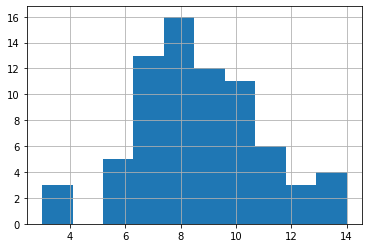

In [79]:
grid_cells_per_survey = merged.groupby(['Area', 'Site', 'Year'], as_index=False)['Grid.Cell.ID'].nunique() # 3-14, mode=8
grid_cells_per_survey['Grid.Cell.ID'].hist()

In [80]:
num_years_per_mpa = merged.groupby('CA_MPA_name_short', as_index = False)['Year'].nunique()
num_years_per_mpa = num_years_per_mpa.sort_values('CA_MPA_name_short')
num_years_per_mpa.to_csv('ccfrp_grid_cells_per_year_2.csv', index=False)